In [15]:
import os
from glob import glob
from tqdm import tqdm
import cv2
from skimage import transform
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import matplotlib.gridspec as gridspec
import seaborn as sns
import zlib
import itertools
import sklearn
import scipy
from skimage.transform import resize
import csv
from sklearn.model_selection import train_test_split, learning_curve, KFold, cross_val_score, StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, accuracy_score
import keras
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.models import Sequential, model_from_json
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import pickle 
from keras.models import load_model

In [2]:
def get_data(folder):
    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['NORMAL']:
                label = 0
            elif folderName in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
            
            full_path = os.path.join(folder, folderName)
            if not os.path.isdir(full_path):
                print(f"Warning: {full_path} is not a directory. Skipping.")
                continue
            
            for image_filename in tqdm(os.listdir(full_path)):
                img_path = os.path.join(full_path, image_filename)
                img_file = cv2.imread(img_path)
                if img_file is not None:
                    img_file = transform.resize(img_file, (150, 150, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X, y

# Make sure train_dir and test_dir end with a slash
train_dir = "/Users/preethambindela/Downloads/chest_xray/train/"
test_dir = "/Users/preethambindela/Downloads/chest_xray/test/"

X_train, y_train = get_data(train_dir)
X_test, y_test = get_data(test_dir)

# Encode labels to hot vectors
from tensorflow.keras.utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes=2)
y_testHot = to_categorical(y_test, num_classes=2)

100%|█████████████████████████████████████| 234/234 [01:14<00:00,  3.14it/s]


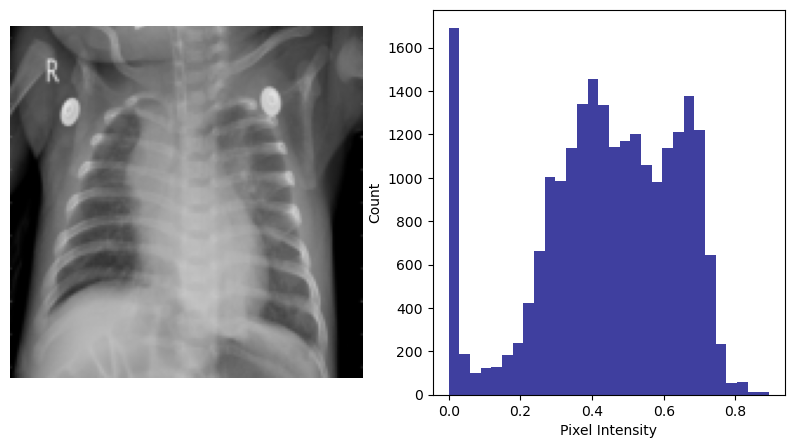

In [3]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X_train[1])

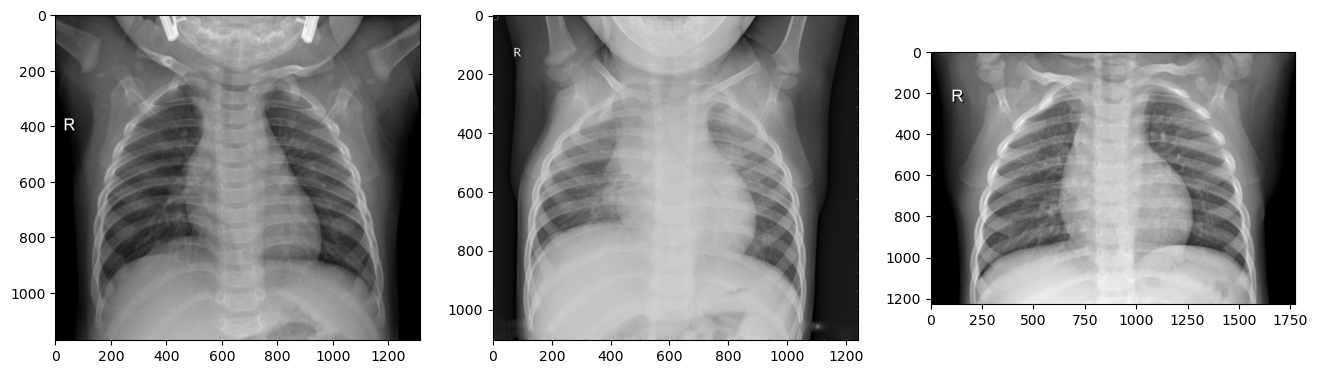

In [4]:
multipleImages = glob('/Users/preethambindela/Downloads/chest_xray/train/NORMAL/*')
def plotThreeImages(images):
    r = random.sample(images, 3)
    plt.figure(figsize=(16,16))
    plt.subplot(131)
    plt.imshow(cv2.imread(r[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(r[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(r[2]));
plotThreeImages(multipleImages)

No Pneumonia


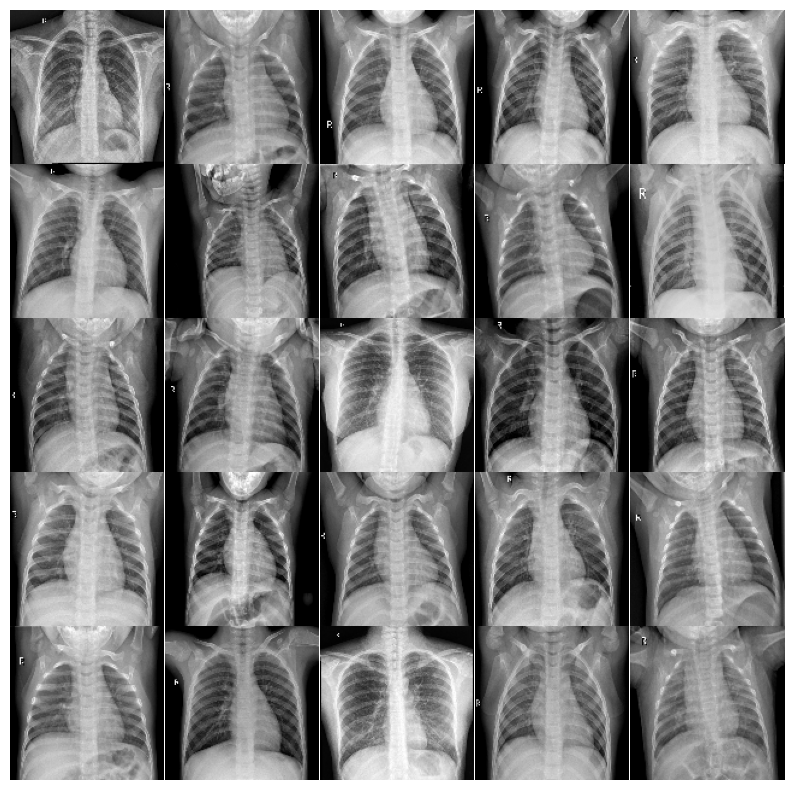

In [5]:
print("No Pneumonia")
multipleImages = glob('/Users/preethambindela/Downloads/chest_xray/train/NORMAL/*')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128))
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

Yes Pneumonia


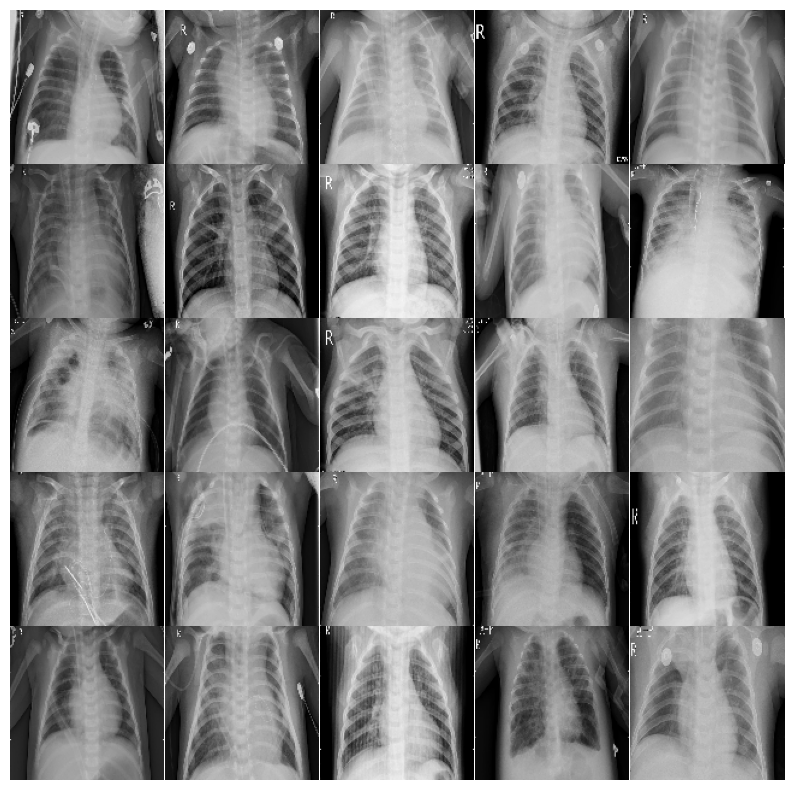

In [6]:
print("Yes Pneumonia")
multipleImages = glob('/Users/preethambindela/Downloads/chest_xray/train/PNEUMONIA/*')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128))
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

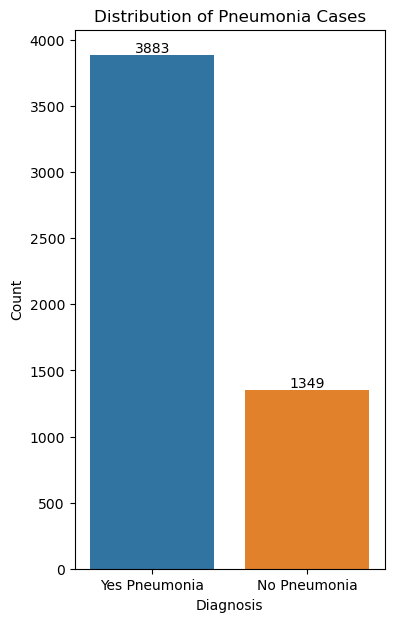

{0: 'No Pneumonia', 1: 'Yes Pneumonia'}
labels_str
Yes Pneumonia    3883
No Pneumonia     1349
Name: count, dtype: int64


In [7]:
map_characters = {0: 'No Pneumonia', 1: 'Yes Pneumonia'}
dict_characters = map_characters

df = pd.DataFrame()
df["labels"] = y_train
df["labels_str"] = df["labels"].map(map_characters)

plt.figure(figsize=(4, 7))
sns.countplot(x='labels_str', data=df)
plt.title('Distribution of Pneumonia Cases')
plt.xlabel('Diagnosis')
plt.ylabel('Count')

# Add count labels on top of each bar
for i, v in enumerate(df['labels_str'].value_counts()):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.show()

print(dict_characters)
print(df['labels_str'].value_counts())

In [8]:
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy', allow_pickle=True)[()]  # Added allow_pickle=True to load object arrays
    #metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.savefig('./loss_curve.png')

In [9]:
from sklearn.utils.class_weight import compute_class_weight

map_characters1 = {0: 'No Pneumonia', 1: 'Yes Pneumonia'}
#class_weight1 = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weight1 = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
weight_path1 = '../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
weight_path2 = '../input/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
#pretrained_model_1 = VGG16(weights = weight_path1, include_top=False, input_shape=(150, 150, 3))
pretrained_model_1 = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
#pretrained_model_2 = InceptionV3(weights = weight_path2, include_top=False, input_shape=(150, 150, 3))
pretrained_model_2 = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
optimizer1 = Adam(learning_rate=0.0001)
###
class_weights_array = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights_array))
###

print("Class Weights: ", class_weight_dict)

def pretrainedNetwork(xtrain,ytrain,xtest,ytest,pretrainedmodel,pretrainedweights,class_weight_dict,numclasses,numepochs,optimizer,labels):
    base_model = pretrained_model_1 # Topless
    # Add top layer
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(numclasses, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    # Train top layer
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    model.summary()
    # Fit model
    history = model.fit(xtrain,ytrain, epochs=numepochs, class_weight=class_weight_dict, validation_data=(xtest,ytest), verbose=1,callbacks = [MetricsCheckpoint('logs')])
    # Evaluate model
    score = model.evaluate(xtest,ytest, verbose=0)
    print('\nKeras CNN - accuracy:', score[1], '\n')
    y_pred = model.predict(xtest)
    print('\n', sklearn.metrics.classification_report(np.where(ytest > 0)[1], np.argmax(y_pred, axis=1), target_names=list(labels.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1)
    Y_true = np.argmax(ytest,axis = 1)
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
    plotKerasLearningCurve()
    plt.show()
    plot_learning_curve(history)
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(labels.values()))
    plt.show()
    return model
#pretrainedNetwork(X_train, y_trainHot, X_test, y_testHot,pretrained_model_1,weight_path1,class_weight1,2,3,optimizer1,map_characters1)

Class Weights:  {0: 1.939214232765011, 1: 0.6737058975019315}


In [10]:
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
import seaborn as sns

# Deal with imbalanced class sizes below
# Make Data 1D for compatibility with sampling methods
X_trainShape = X_train.shape[1] * X_train.shape[2] * X_train.shape[3]
X_testShape = X_test.shape[1] * X_test.shape[2] * X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
Y_train = y_train
Y_test = y_test

# Use RandomUnderSampler with updated parameter name
rus = RandomUnderSampler(sampling_strategy='auto')
X_trainRus, Y_trainRus = rus.fit_resample(X_trainFlat, Y_train)

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainRusHot = to_categorical(Y_trainRus, num_classes=2)
Y_testHot = to_categorical(Y_test, num_classes=2)  # Use original Y_test

# Make Data 2D again
height, width, channels = 150, 150, 3
X_trainRusReshaped = X_trainRus.reshape(-1, height, width, channels)

# Note: We're not reshaping X_testRus as we didn't undersample it
X_testReshaped = X_test  # Use original X_test

In [11]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# For the original dataset
class_weight1 = compute_class_weight(class_weight='balanced', 
                                     classes=np.unique(Y_train), 
                                     y=Y_train)
print("Old Class Weights: ", class_weight1)

# For the resampled dataset
class_weight2 = compute_class_weight(class_weight='balanced', 
                                     classes=np.unique(Y_trainRus), 
                                     y=Y_trainRus)
print("New Class Weights: ", class_weight2)

Old Class Weights:  [1.93921423 0.6737059 ]
New Class Weights:  [1. 1.]


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │        16,386 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,731,074 (56.19 MB)

 Trainable params: 16,386 (64.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 490s 6s/step - accuracy: 0.5162 - loss: 0.7526 - val_accuracy: 0.7869 - val_loss: 0.5136
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 911s 11s/step - accuracy: 0.8371 - loss: 0.3676 - val_accuracy: 0.8462 - val_loss: 0.3967
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 875s 10s/step - accuracy: 0.8951 - loss: 0.2575 - val_accuracy: 0.8606 - val_loss: 0.3427
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 754s 9s/step - accuracy: 0.9041 - loss: 0.2226 - val_accuracy: 0.8878 - val_loss: 0.3000
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 691s 8s/step - accuracy: 0.9260 - loss: 0.1818 - val_accuracy: 0.8878 - val_loss: 0.2864
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 775s 9s/step - accuracy: 0.9339 - loss: 0.1674 - val_accuracy: 0.8926 - val_loss: 0.2801
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 744s 9s/step - accuracy: 0.9351 - loss: 0.1648 - val_accuracy: 0.9006 - val_loss: 0.2700
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 392s 5s/step - accuracy: 0.9453 - loss: 0.1463 - val_accuracy: 0.8926 -

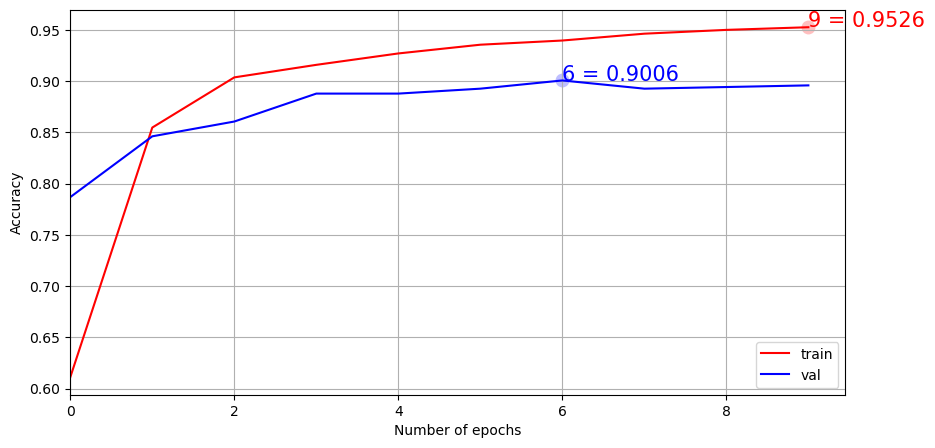

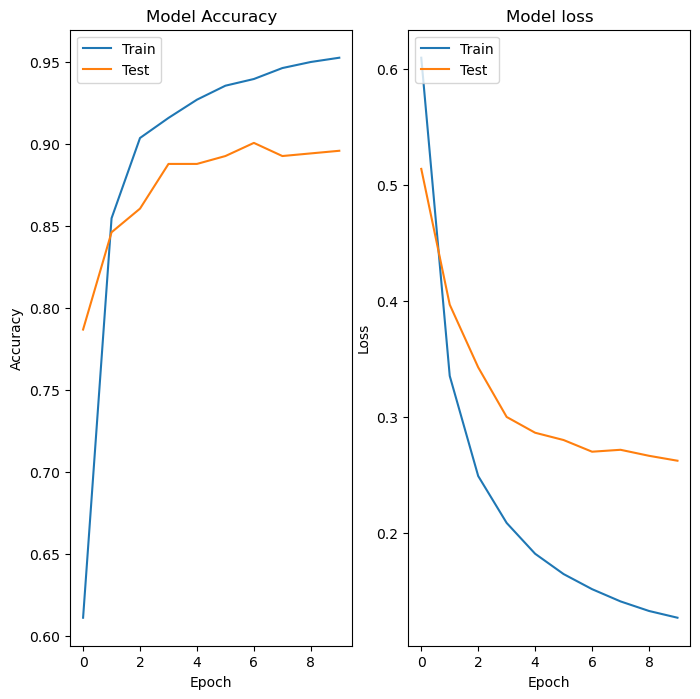

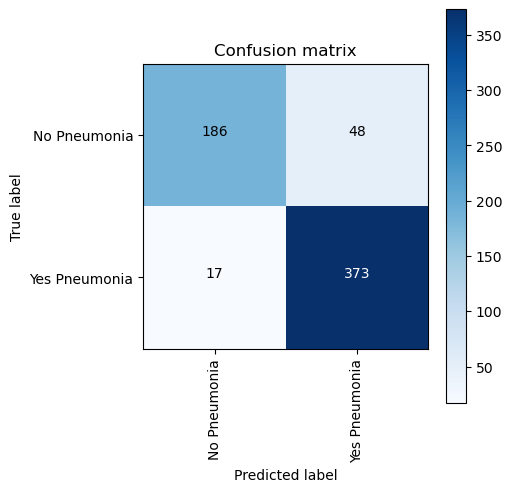

In [12]:
model_pneumonia = pretrainedNetwork(X_trainRusReshaped, Y_trainRusHot, X_testReshaped, Y_testHot,pretrained_model_1,weight_path1,class_weight_dict,2,10,optimizer1,map_characters1)


In [13]:
# Save the model to an HDF5 file
model_pneumonia.save('model_pneumonia.h5')


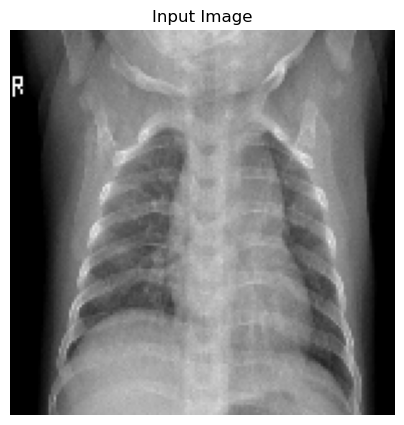

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[[0.63262665 0.3673733 ]]
Prediction: No Pneumonia


In [16]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Define the image path
img_path = '/Users/preethambindela/Downloads/chest_xray/test/NORMAL/NORMAL2-IM-0340-0001.jpeg'  # Replace with the correct path

model_pneumonia = load_model('model_pneumonia.h5')

# Step 2: Preprocess the image
img = image.load_img(img_path, target_size=(150,150))  # Resize to match input size
img_array = image.img_to_array(img)  # Convert the image to an array
img_array = np.expand_dims(img_array, axis=0)  # Expand dims to add batch size
img_array /= 255.0  # Normalize the image

# Step 3: Display the image
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.title('Input Image')
plt.show()

# Step 4: Make a prediction using the model
prediction = model_pneumonia.predict(img_array)

print(prediction)

# Assuming it's a binary classification (pneumonia or no pneumonia)
if prediction[0][1] > 0.5:
    print("Prediction: Yes Pneumonia")
else:
    print("Prediction: No Pneumonia")


In [21]:
model.save('pneumonia_model.h5')

In [29]:
model = load_model('pneumonia_model.h5')

In [30]:
model.save('pneumonia_model.h5')